# NLP Midterm Project — Multinomial Naïve Bayes on TripAdvisor **Reviews**

Import Library

In [ ]:
import os, re
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data Acqusition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/tripadvisor_hotel_reviews.csv"
df = pd.read_csv(DATA_PATH)

Identify Columns

In [ ]:
text_col = None
label_col = None
for cand in ["Review","review","Text","text","content","Review_Text"]:
    if cand in df.columns:
        text_col = cand
        break
for cand in ["Rating","rating","Score","score","stars","Stars","Sentiment","label"]:
    if cand in df.columns:
        label_col = cand
        break
if text_col is None:
    text_col = df.columns[0]
if label_col is None:
    label_col = "AutoLabel"
    import numpy as np
    rng = np.random.default_rng(42)
    df[label_col] = rng.choice(["positive","negative","neutral"], size=len(df))
df.head(3)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3


Sentiment Mapping

In [ ]:
import numpy as np
if np.issubdtype(df[label_col].dtype, np.number):
    def map_rating(r):
        try:
            r = float(r)
        except Exception:
            return "neutral"c
        if r >= 4.0:
            return "positive"
        elif r <= 2.0:
            return "negative"
        else:
            return "neutral"
    df["sentiment"] = df[label_col].apply(map_rating)
else:
    def norm_label(x):
        s = str(x).strip().lower()
        if s in ["pos","positive","1","5","good","great","excellent","true"]:
            return "positive"
        if s in ["neg","negative","0","1-star","bad","poor","false"]:
            return "negative"
        if s in ["neutral","neut","3","mixed"]:
            return "neutral"
        return "neutral"
    df["sentiment"] = df[label_col].apply(norm_label)
df["sentiment"].value_counts()

,count
sentiment,
positive,15093
negative,3214
neutral,2184


Case Folding

In [ ]:
df["text_lower"] = df[text_col].astype(str).str.lower()
df[["text_lower","sentiment"]].head(3)

,text_lower,sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,negative
2,nice rooms not 4* experience hotel monaco seat...,neutral


Punctuation Removal

In [ ]:
text_remove_mapping = str.maketrans("", "", string.punctuation)
df["text_no_punct"] = df["text_lower"].apply(lambda x: x.translate(text_remove_mapping).strip())
df[["text_no_punct","sentiment"]].head(3)

,text_no_punct,sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,negative
2,nice rooms not 4 experience hotel monaco seatt...,neutral


Tokenization

In [ ]:
df["tokens"] = df["text_no_punct"].apply(word_tokenize)
df[["tokens","sentiment"]].head(3)

,tokens,sentiment
0,"[nice, hotel, expensive, parking, got, good, d...",positive
1,"[ok, nothing, special, charge, diamond, member...",negative
2,"[nice, rooms, not, 4, experience, hotel, monac...",neutral


Stop Words Removal

In [ ]:
stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
df["tokens_no_stop"] = df["tokens"].apply(lambda ts: [t for t in ts if t not in stop_words])
df[["tokens_no_stop","sentiment"]].head(3)

,tokens_no_stop,sentiment
0,"[nice, hotel, expensive, parking, got, good, d...",positive
1,"[ok, nothing, special, charge, diamond, member...",negative
2,"[nice, rooms, not, 4, experience, hotel, monac...",neutral


Lemmatization

In [ ]:
'''
stemmer = PorterStemmer()
df["lemmatized"] = df["tokens_no_stop"].apply(lambda ts: [stemmer.stem(t) for t in ts])
df[["lemmatized", "sentiment"]].head(3)
'''
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
df["lemmatized"] = df["tokens_no_stop"].apply(lambda ts: [lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in ts])
df[["lemmatized","sentiment"]].head(3)

'\nlemmatizer = WordNetLemmatizer()\ndef get_wordnet_pos(word):\n    tag = nltk.pos_tag([word])[0][1][0].upper()\n    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}\n    return tag_dict.get(tag, wordnet.NOUN)\ndf["lemmatized"] = df["tokens_no_stop"].apply(lambda ts: [lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in ts])\ndf[["lemmatized","sentiment"]].head(3)\n'

Join tokens for TF-IDF Vectorization

In [ ]:
df["text_clean"] = df["lemmatized"].apply(lambda ts: " ".join(ts))
df[["text_clean","sentiment"]].head(3)

,text_clean,sentiment
0,nice hotel expens park got good deal stay hote...,positive
1,ok noth special charg diamond member hilton de...,negative
2,nice room not 4 experi hotel monaco seattl goo...,neutral


Train-Test Split

In [ ]:
X = df["text_clean"].values
y = df["sentiment"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
len(X_train), len(X_test)

(16392, 4099)

TF IDF vectorization

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape

((16392, 10000), (4099, 10000))

Naive Bayes Training and Evaluation

In [ ]:
nb = MultinomialNB(alpha=0.5)
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
print(acc, prec, rec, f1)
print(classification_report(y_test, y_pred, zero_division=0))

0.839473042205416 0.6904030918848828 0.5739653466508482 0.5651621852192966
              precision    recall  f1-score   support

    negative       0.79      0.72      0.76       643
     neutral       0.43      0.01      0.03       437
    positive       0.85      0.98      0.91      3019

    accuracy                           0.84      4099
   macro avg       0.69      0.57      0.57      4099
weighted avg       0.80      0.84      0.79      4099



Confusion Matrix Plot

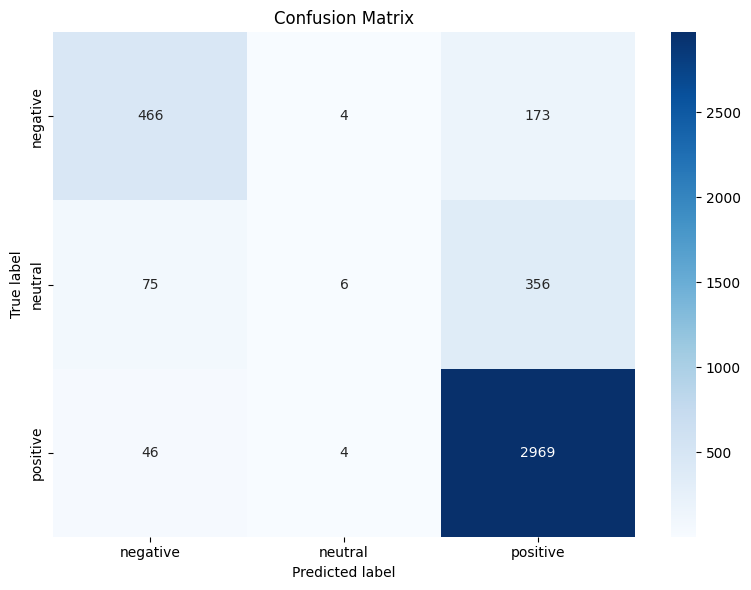

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = sorted(list(set(y_test)))
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

Top Features per Class

In [ ]:
import numpy as np
feature_names = np.array(tfidf.get_feature_names_out())
topn = 20
for c, idx in zip(nb.classes_, range(len(nb.classes_))):
    order = np.argsort(nb.feature_log_prob_[idx])[::-1][:topn]
    feats = feature_names[order]
    print(c, feats.tolist())

negative ['not', 'room', 'hotel', 'nt', 'no', 'stay', 'night', 'day', 'servic', 'time', 'told', 'resort', 'like', 'bed', 'place', 'staff', 'good', 'book', 'check', 'desk']
neutral ['hotel', 'room', 'not', 'good', 'nt', 'stay', 'locat', 'nice', 'no', 'night', 'great', 'clean', 'ok', 'beach', 'small', 'like', 'time', 'staff', 'resort', 'price']
positive ['hotel', 'room', 'great', 'stay', 'not', 'locat', 'good', 'staff', 'nt', 'nice', 'love', 'clean', 'night', 'walk', 'excel', 'breakfast', 'time', 'help', 'servic', 'place']
